# NYC Schools SAT – Exploratory Case Study

**Author:** Andreza Eufrasio

**Goal:** Analyze NYC schools’ SAT scores to uncover subject-level and overall performance patterns. Provide clear, data-driven insights that can guide education policies and family school choices.

![New York City schoolbus](schoolbus.jpg)

Photo by [Jannis Lucas](https://unsplash.com/@jannis_lucas) on [Unsplash](https://unsplash.com).#<br>


## Business Context
The SAT has three sections—reading, math, and writing—each scored 0–800. Analyzing NYC schools’ SAT results at both the school and borough levels reveals excellence, gaps, and variability. These insights help educators, policymakers, researchers, and families allocate resources, design programs, and choose schools to improve college readiness.


---

## Key Questions:
1. What is the distribution of scores across math, reading, and writing?
2. How do average scores compare across subjects?
3. Which NYC schools have the best math results? (≥ 640 / 800)
4. What are the top 10 performing schools based on combined SAT scores?
5. Which schools fall below NYC’s median SAT performance?
6. What is the performance gap between the highest and lowest schools?
7. Which boroughs have the highest and lowest average SAT scores?
8. Which single borough has the largest standard deviation in combined SAT scores? 
9. Is there a relationship between number of schools in a borough and its average SAT?
10. Do boroughs show consistent subject strengths (math vs reading vs writing)?
11. If we rank schools into quartiles by total SAT, what characteristics do top-quartile schools share vs bottom-quartile schools?

---

## Deliverables

* **Answers to 11 research questions** on NYC high-school SAT performance, using both strict (participation ≥50% & known) and **unscreened** views where relevant.

* **School-level analysis**: distributions (hist/box), medians & IQR (with means for context), subject comparisons, **high-math (≥640)** list, **top-10 total SAT**, and **below-median** tiering (near/moderate/far-below).

* **Borough-level analysis**: rankings (highest/lowest), means/medians, **dispersion** (IQR/SD), **subject strengths**, and stability across screens.

* **Gap analysis: max–min** extremes plus **robust spread** (IQR, p90–p10) to contextualize outliers.

* **Quartile breakdowns (Q1–Q4)**: profiles by total SAT, subject medians, participation, and borough mix.

* **Participation-aware reporting**: percent_tested, low_participation, and pt_note flags; transparency via unscreened tables.

* **Reproducible Jupyter notebook** with clean preprocessing (column normalization, type coercion, total_SAT build, NA handling), structured code, and commentary.

* **Actionable recommendations** highlighting strengths, gaps, and where to focus resources.

---

## Dataset

* **File:** `data/schools.csv`
* **Source:** DataCamp (educational use
* **Description:** NYC high-school SAT dataset with school/borough identifiers, **average subject scores** (Math, Reading, Writing; 0–800 each) and **percent\_tested** (0–100), share of students who took the SAT. The project derives **`total_SAT`** (sum of the three subjects) and participation flags **`low_participation`**, **`pt_note`**, **`participation_ok`** used for “strict vs. unscreened” analyses.

---

## Data Dictionary: NYC School SAT Performance Metrics

* **school\_name** *(string)* — School name.
* **borough** *(string)* — NYC borough.
* **building\_code** *(string)* — NYC DOE building/school code.
* **average\_math** *(float, 0–800)* — Average SAT Math score.
* **average\_reading** *(float, 0–800)* — Average SAT Reading score.
* **average\_writing** *(float, 0–800)* — Average SAT Writing score.
* **percent\_tested** *(float, 0–100)* — Percent of enrolled students who took the SAT; may be **NaN** if not reported.

**Derived in notebook**

* **total\_SAT** *(float, 0–2400)* — `average_math + average_reading + average_writing` (uses available values; **NaN** only if all three are missing).
* **low\_participation** *(bool)* Flag for **SAT participation below threshold** — `percent_tested < PT` when reported; highlights potentially **unrepresentative** results and used to **exclude** rows in strict analyses.*(PT = 50 by default.)*
* **pt\_note** *(string)* — Participation status shown in **unscreened** tables (no rows dropped):

  * `""` → meets threshold (≥ PT)
  * `"⚠️ <PT% tested"` → below threshold
  * `"(percent_tested NA)"` → participation missing
    *(PT = 50 by default.)*
    
* **participation\_ok** *(bool)* — **True** when `percent_tested` is reported **and ≥ PT**; **False** otherwise. Used to include rows in the **strict (participation-aware)** view. *(PT = 50 by default.)*

---

## Requirements

* Python 3.12.7
* pip install -r requirements.txt

---

## How to Reproduce

### Option A — JupyterLab (recommended)

1. **Get the data:** place `data/schools.csv` in the repo’s `data/` folder.
   *(If your file lives elsewhere, update `CSV_PATH` at the top of the notebook.)*
2. **Launch JupyterLab** from the repo root:


   ```bash
   jupyter lab
   ```

   
3. **Open** `nyc_schools_sat_score_case_study.ipynb`.
4. In JupyterLab, enable the left **Table of Contents** via **View → Table of Contents**.
5. **Run the analysis:** **Run → Run All Cells** (top to bottom).
6. **Inspect results:** Answers to **Q1–Q11** (plots, tables, insights, recommendations) appear under each section.

### Option B — Start in Classic Notebook, then switch to JupyterLab

1. Launch Classic Notebook:


   ```bash
   jupyter notebook
   ```
   
2. Open `nyc_schools_sat_score_case_study.ipynb`.
3. In the top menu, choose **View → Open in JupyterLab** to switch.
   *(This opens the same notebook in JupyterLab so you can use the sidebar Table of Contents.)*
4. Then follow steps **4–6** from **Option A**. 


#  Load & Inspect Data

In [294]:
# library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown



# Read in the data
schools = pd.read_csv("schools.csv", encoding = "utf-8")
#schools.head()


In [296]:
# Normalize column names (common variants across Netflix datasets)

schools.columns = (schools.columns
                      .str.strip().str.lower()
                      .str.replace(r"[ /\-\(\)]+", "_", regex =True)
                      .str.replace(r"_+", "_", regex=True)
                      .str.strip("_")
                     )
schools.head()


,school_name,borough,building_code,average_math,average_reading,average_writing,percent_tested
0,"New Explorations into Science, Technology and ...",Manhattan,M022,657,601,601,NaN
1,Essex Street Academy,Manhattan,M445,395,411,387,78.9
2,Lower Manhattan Arts Academy,Manhattan,M445,418,428,415,65.1
3,High School for Dual Language and Asian Studies,Manhattan,M445,613,453,463,95.9
4,Henry Street School for International Studies,Manhattan,M056,410,406,381,59.7


In [298]:
schools.shape

(375, 7)

#  Data Quality Checks

## Basic Info(rows, coulumns)

In [302]:
# Basic info

print(f" Rows:{schools.shape[0]} and Columns:{schools.shape[1]}", "\n")


schools.info()

 Rows:375 and Columns:7 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   school_name      375 non-null    object 
 1   borough          375 non-null    object 
 2   building_code    375 non-null    object 
 3   average_math     375 non-null    int64  
 4   average_reading  375 non-null    int64  
 5   average_writing  375 non-null    int64  
 6   percent_tested   355 non-null    float64
dtypes: float64(1), int64(3), object(3)
memory usage: 20.6+ KB


## Values out of bounds for percent-tested column

In [305]:
s = schools["percent_tested"]

# Are any values out of bounds?
bad = ((s < 0) | (s > 100)).sum()
bad


0

## NA Check (per column)

In [308]:
schools.isna().sum()

school_name         0
borough             0
building_code       0
average_math        0
average_reading     0
average_writing     0
percent_tested     20
dtype: int64

## NA Check (Coerce to Numeric: "average_math", "average_reading", "average_writing", "percent_tested")
  * Any stray non-numeric values in "average_math", "average_reading", "average_writing", "percent_tested" are coerced to NaN.
  * Validate — NaN Counts After Coercion


In [311]:
# List of numeric-like columns you want to check
columns_to_check = ["average_math", "average_reading", "average_writing", "percent_tested"]

# Loop through each and report non-numeric values
for col in columns_to_check:
    # Try to convert to numeric (will turn invalid entries into NaN)
    converted = pd.to_numeric(schools[col], errors="coerce")
    
    # Count how many values could not be converted (i.e., became NaN)
    num_invalid = converted.isna().sum() - schools[col].isna().sum()
    
    if num_invalid > 0:
        print(f"⚠️ Column '{col}' has {num_invalid} non-numeric value(s).")
    else:
        print(f"✅ Column '{col}' is fully numeric.")



✅ Column 'average_math' is fully numeric.
✅ Column 'average_reading' is fully numeric.
✅ Column 'average_writing' is fully numeric.
✅ Column 'percent_tested' is fully numeric.


In [313]:
# Define function first
def check_and_count_na(series):
    na_count = series.isna().sum()
    if na_count == 0:
        print("0 (no NaN values)")
    else:
        print(f"1 (has NaN values) — Total NaNs: {na_count}")

# Convert columns afterwards
num_cols = ["average_math", "average_reading", "average_writing", "percent_tested"]
schools[num_cols] = schools[num_cols].apply(pd.to_numeric, errors='coerce')

for col in num_cols:
    check_and_count_na(schools[col])


0 (no NaN values)
0 (no NaN values)
0 (no NaN values)
1 (has NaN values) — Total NaNs: 20


* All score columns have 0 missing.

* Only percent_tested has 20 NaNs out of 375 rows (≈ 5.3%).

## Detect Placeholder Values in Categorical Columns

In [317]:
# Detect & Count Bad Placeholders in Categorical Columns
bad_values = ["?", "N/A", "NA", "n/a", "Unknown", "unknown", "None", "", " ", "-", "--"]


for col in schools.select_dtypes(include= ['object', 'string', 'category']).columns:
    bad_count = schools[col].isin(bad_values).sum()
    if bad_count > 0:
        print(f" ⚠️ Column: '{col}' has {bad_count} bad values","\n")
    else:
        print(f" ✅ Column:'{col}' has zero bad values", "\n")

 ✅ Column:'school_name' has zero bad values 

 ✅ Column:'borough' has zero bad values 

 ✅ Column:'building_code' has zero bad values 



## Duplicate Checks 

In [320]:
print("Exact duplicate row:", schools.duplicated().sum(), "\n")


Exact duplicate row: 0 



## Comprehensive Descriptive Statistics

In [323]:
cols = ["average_math", "average_reading", "average_writing", "percent_tested"]

# Start from describe, then add what you want
summary = schools[cols].describe().T                         # count, mean, std, min, 25%, 50%, 75%, max
summary = summary.rename(columns={"50%": "50% (median)"})
summary["variance"] = schools[cols].var(ddof=1)              # sample variance (ddof=1)
summary["iqr"]      = summary["75%"] - summary["25%"]
summary["skew"]     = schools[cols].skew()

summary.round(2)


,count,mean,std,min,25%,50% (median),75%,max,variance,iqr,skew
average_math,375.0,432.94,71.95,317.0,386.00,415.0,458.5,754.0,5177.14,72.50,1.72
average_reading,375.0,424.50,61.88,302.0,386.00,413.0,445.0,697.0,3829.27,59.00,1.63
average_writing,375.0,418.46,64.55,284.0,382.00,403.0,437.5,693.0,4166.52,55.50,1.68
percent_tested,355.0,64.98,18.75,18.5,50.95,64.8,79.6,100.0,351.47,28.65,-0.09


# Q1) What is the distribution of scores across math, reading, and writing?

In [326]:
subj = ["average_math","average_reading","average_writing"]
stats = pd.DataFrame({
    "count":   schools[subj].count(),
    "mean":    schools[subj].mean(),
    "median":  schools[subj].median(),
    "std":     schools[subj].std(ddof=0),
    "iqr":     schools[subj].quantile(0.75)-schools[subj].quantile(0.25),
    "p90-p10": schools[subj].quantile(0.90)-schools[subj].quantile(0.10),
    "min":     schools[subj].min(),
    "max":     schools[subj].max(),
    "skew":    schools[subj].skew()
}).round(1)
stats


,count,mean,median,std,iqr,p90-p10,min,max,skew
average_math,375,432.9,415.0,71.9,72.5,150.6,317,754,1.7
average_reading,375,424.5,413.0,61.8,59.0,122.8,302,697,1.6
average_writing,375,418.5,403.0,64.5,55.5,129.6,284,693,1.7


**Subject summary: median • IQR • mean • 5% trimmed mean**

In [329]:
from scipy.stats import trim_mean

subj = ["average_math","average_reading","average_writing"]
summary = pd.DataFrame({
    "median":  schools[subj].median(),
    "IQR":     schools[subj].quantile(0.75) - schools[subj].quantile(0.25),
    "mean":    schools[subj].mean(),
    "trimmed_mean_5%": [trim_mean(schools[c].dropna(), 0.05) for c in subj],
}).round(1)
summary


,median,IQR,mean,trimmed_mean_5%
average_math,415.0,72.5,432.9,425.8
average_reading,413.0,59.0,424.5,419.2
average_writing,403.0,55.5,418.5,412.7



**“Why we use the median”**

**Center metric:** We report the **median** (with IQR) because the score distributions are **right-skewed** and the high “outliers” are **real authentic top schools** (not errors). The median is robust to these extremes and better represents a *typical school*, whereas the mean is pulled upward by the right tail.

**For transparency**, we also compute the mean and a 5% trimmed mean in the summary table. Trimming lowers the mean by ~7.1 (math), 5.3 (reading), 5.8 (writing)—about 1.6% / 1.3% / 1.4%—quantifying how the upper tail lifts the average. Our conclusions are based on median/IQR; means are reference only.




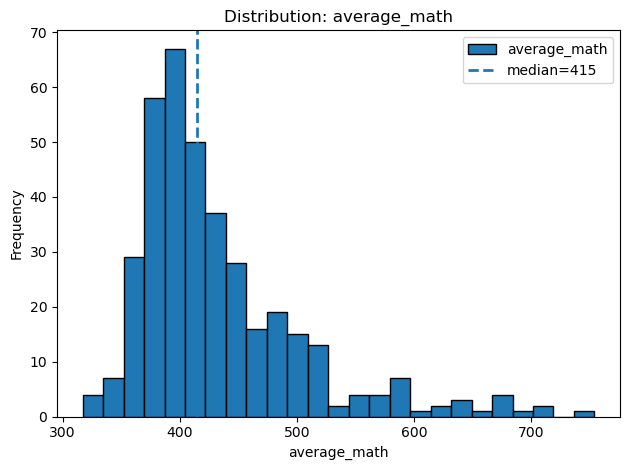

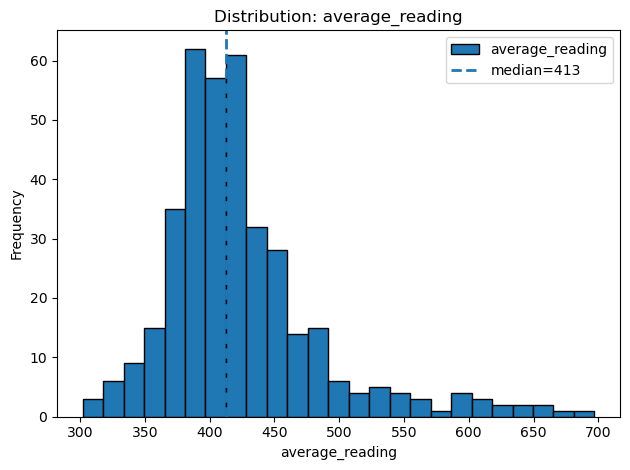

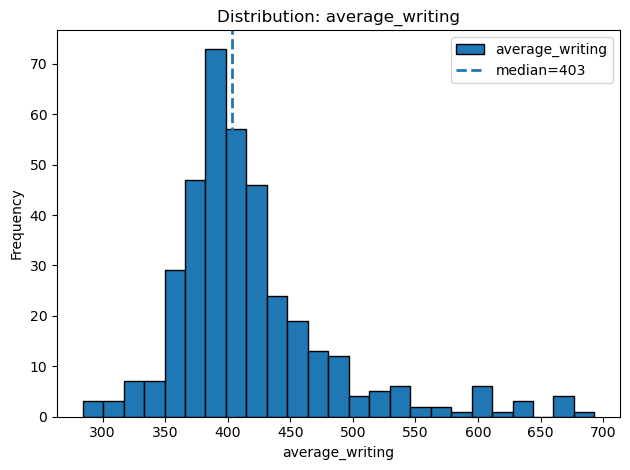

In [332]:
for col in ["average_math","average_reading","average_writing"]:
    fig, ax = plt.subplots()
    schools[col].dropna().plot(kind="hist", bins=25, edgecolor="black", ax=ax)
    med = schools[col].median()
    ax.axvline(med, linestyle="--", linewidth=2, label=f"median={med:.0f}")
    ax.set(title=f"Distribution: {col}", xlabel=col, ylabel="Frequency")
    ax.legend()
    fig.tight_layout()
    plt.show()


<details>
<summary><b>Interpretation details</b></summary>
    
* **Unimodal with right-skew:** All three subjects have a single main hump with a **long right tail**—a small set of **high-performing schools** pulls the distribution upward.
* **Center:** Most schools cluster in the **low–mid 400s**. Medians: **math ≈ 415 > reading ≈ 413 > writing ≈ 403**.
* **Spread:** **Math** has the largest variability (IQR ≈ 72.5), then reading (IQR ≈ 59.0) and writing (IQR ≈ 55.5). Middle mass is broad; tails are thin.
* **Rare extremes:** A few schools reach the **600–700+** range, consistent with selective/specialized programs; low extremes are comparatively rare.
*  **Median line:** The dashed line marks the median (typical school); the mean is higher due to right-skew.

</details>


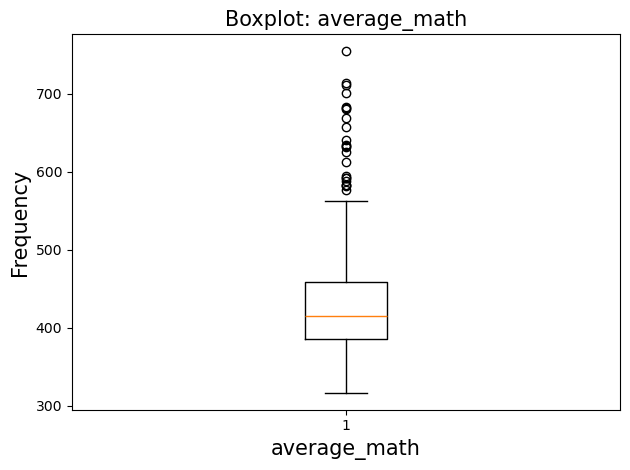

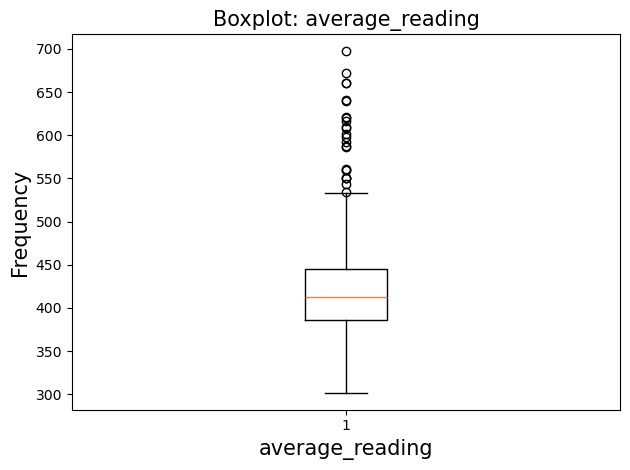

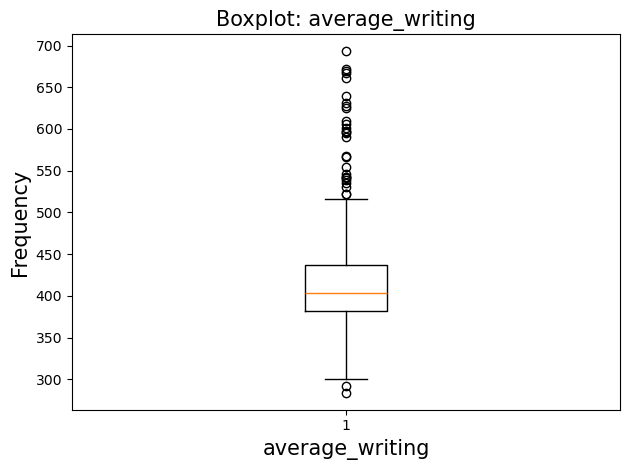

In [334]:
for col in ["average_math","average_reading","average_writing"]:
    plt.figure()
    plt.boxplot(schools[col])
    plt.title(f"Boxplot: {col}", fontsize =15)
    plt.xlabel(col, fontsize =15)
    plt.ylabel("Frequency", fontsize =15)
    plt.tight_layout() 
    plt.show()


<details>
<summary><b>Interpretation details</b></summary>
    
* **Median (center):** **Math \~415 > Reading \~413 > Writing \~403.**
* **Spread (IQR):** Variability is broadly similar, but **math is widest** (**IQR ≈ 72.5**) vs **reading ≈ 59.0**, **writing ≈ 55.5**.
* **Skew & whiskers:** **Upper whiskers extend further** than lower ones for all subjects and there are **many points beyond Q3 + 1.5×IQR**—classic **right-skew**; low outliers are comparatively few.
* **Outliers:** These are likely **selective/top-performing schools**. They are **informative, not errors**, so favor **robust summaries (median/IQR)** alongside any mean-based metrics.
* **Boxes** show the interquartile range (middle 50%); the horizontal line is the median; whiskers extend to the most extreme points within **1.5×IQR** of the box; dots beyond the whiskers are outliers.*




</details>


## Insights (from histograms & boxplots)

* **Shape:** All three subjects are **right-skewed** (a small set of very high-performing schools pulls the right tail). As a result, **means sit above medians**.
* **Center (typical school):** medians ≈ **Math 415**, **Reading 413**, **Writing 403** (low–mid 400s).
* **Spread:** **Math varies the most** — **IQR ≈ 72.5** vs **Reading ≈ 59.0** and **Writing ≈ 55.5**.
* **Whiskers & outliers:** **Upper whiskers are longer** and there are **many high outliers**; **low outliers are rare**. These points are real (selective/top schools), not errors.

## Why this matters

* **Use robust summaries:** Because of the right skew, report **median + IQR** (and optionally p90–p10 or a trimmed mean) to describe a *typical* school; the mean alone overstates the center.
* **Target gains vs. variability:** The subject ordering and spreads show **where gains are most needed**—**writing/reading** (lower medians)—and **where variation is largest**—**math** (widest IQR ≈ **72.5** vs **59.0** reading, **55.5** writing).
* **Outliers are informative:** High outliers are real (selective/top schools), explaining elevated means and offering benchmarks for later comparisons (e.g., by borough or school type).


# Q2) How do average scores compare across subjects?

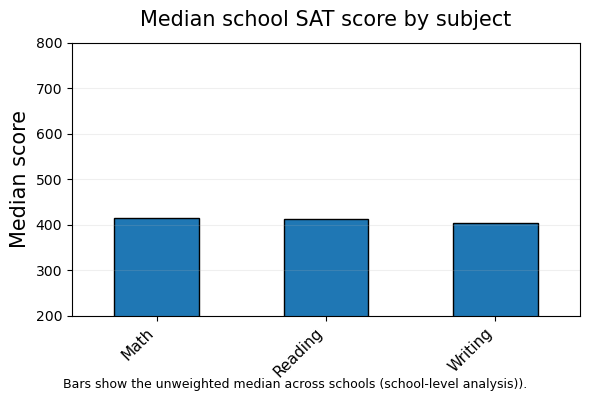

,median,mean
average_math,415.0,432.9
average_reading,413.0,424.5
average_writing,403.0,418.5


In [339]:

subj = ["average_math","average_reading","average_writing"]
means = schools[subj].median().round(2)  # unweighted mean across schools

fig, ax = plt.subplots(figsize=(6,4))
means.plot(kind="bar", ax=ax, edgecolor="black")

ax.set_title("Median school SAT score by subject", pad=12, fontsize =15)
ax.set_ylabel("Median score", fontsize =15)
ax.set_xlabel("")
ax.set_xticklabels(["Math", "Reading", "Writing"], rotation=45, ha="right", fontsize =11)

# Optional: show the SAT section scale
ax.set_ylim(200, 800)
ax.set_yticks(range(200, 801, 100))

ax.grid(axis="y", alpha=0.2)
fig.tight_layout()

# Footnote to make the unit-of-analysis explicit
fig.text(0.5, 0.01, "Bars show the unweighted median across schools (school-level analysis)).",
         ha="center", va="bottom", fontsize=9)

plt.show()

#means.to_frame("Subject_Median")

summary = pd.DataFrame({
    "median":  schools[subj].median(),
    "mean":    schools[subj].mean(),
}).round(1)
summary


## Insights(median & mean across schools):

* **Ordering is the same either way:** **Math** is highest, then **Reading**, then **Writing**.
* **Typical scores (medians):** Math ≈ **415**, Reading ≈ **413**, Writing ≈ **403**.
* **Means are very close to medians** (only \~**5–10 points higher**, depending on the subject), which is exactly what we expect with a **right-skewed** distribution (a small group of high-performing schools lifts the mean a bit).
* **Subject gaps are modest:** Math is ≈ **+2** over Reading and ≈ **+12** over Writing at the median;Reading is \~**+10** above Writing. The mean shows a similar spread.
* These **cross-subject differences are small** compared with the **between-school spread** you saw in Q1 (IQRs ≈ 72.5 math, 59.0 reading, 55.5 writing).

## Why this matters**

* **Robust + transparent:** Showing **both median and mean** confirms the pattern doesn’t depend on one statistic. We’ll **center analyses on medians/IQR** (robust to outliers) but include means to show the skew isn’t driving the conclusion.
* **Instructional signal:** Since the gaps are **modest across subjects**, broad improvements shouldn’t hinge on a single subject—though **writing** trails a bit and **math** has a slight edge.
* **Performance framing:** Emphasize that **most variation is between schools**, not between subjects—so supports should focus on **school-level practices** rather than big shifts in subject mix.


# Q3) Which NYC schools have the best math results? (≥ 640 / 800)

In [343]:
PT = 50  # tune: 50%  (strict)

# flag & annotate participation
schools["low_participation"] = (schools["percent_tested"] < PT) & schools["percent_tested"].notna()
schools["pt_note"] = np.select(
    [schools["percent_tested"].isna(), schools["low_participation"]],
    ["(percent_tested NA)", f"⚠️ <{PT}% tested"],
    default=""
)


In [344]:
cut = 0.8 * 800  # 640
cols = ["school_name","borough","average_math","percent_tested","pt_note","low_participation"]


# your original list (all schools meeting the score cut)
top_math_all = (schools.loc[schools["average_math"] >= cut, cols].sort_values("average_math", ascending =False).reset_index(drop=True))
                                                                                                         
# participation-screened list (recommended to show as the main table)
top_math_strict = top_math_all.loc[
   (~top_math_all["low_participation"]) & (top_math_all["percent_tested"].notna())
].reset_index(drop=True)

# quick counts
n_all = len(top_math_all)
n_flag = int(top_math_all["low_participation"].sum())
n_strict = len(top_math_strict)
print(f"{n_all} schools have average_math ≥ {cut:.0f}.  Flagged for low participation (<{PT}%): {n_flag}.  Remaining after filter: {n_strict}.","\n")


# borough breakdown (optional)
by_boro_all    = top_math_all.groupby("borough")["school_name"].count().sort_values(ascending=False)
by_boro_strict = top_math_strict.groupby("borough")["school_name"].count().sort_values(ascending=False)


# Strict (default) table
display(Markdown("**Strict view** (default)\nSchools with **average_math ≥ 640** **and** `percent_tested ≥ 50%` (not missing)."))
display(top_math_strict.head(10))
#display(top_math_strict.sort_values("average_math", ascending=False).head(10))

# Unscreened table for transparency
display(Markdown("> **Unscreened view** — includes schools with unknown/low participation."))
display(top_math_all.head(10))

# borough breakdown (optional)
by_boro_all    = top_math_all.groupby("borough")["school_name"].count().sort_values(ascending=False)
by_boro_strict = top_math_strict.groupby("borough")["school_name"].count().sort_values(ascending=False)


display(by_boro_strict.to_frame("Borough_strict count"))            # borough counts after screen

display(by_boro_all.to_frame("Borough count"))                    # boroug

10 schools have average_math ≥ 640.  Flagged for low participation (<50%): 0.  Remaining after filter: 9. 



**Strict view** (default)
Schools with **average_math ≥ 640** **and** `percent_tested ≥ 50%` (not missing).

,school_name,borough,average_math,percent_tested,pt_note,low_participation
0,Stuyvesant High School,Manhattan,754,97.4,,False
1,Bronx High School of Science,Bronx,714,97.0,,False
2,Staten Island Technical High School,Staten Island,711,99.7,,False
3,Queens High School for the Sciences at York Co...,Queens,701,97.9,,False
4,"High School for Mathematics, Science, and Engi...",Manhattan,683,92.6,,False
5,Brooklyn Technical High School,Brooklyn,682,95.5,,False
6,Townsend Harris High School,Queens,680,97.1,,False
7,High School of American Studies at Lehman College,Bronx,669,91.8,,False
8,Eleanor Roosevelt High School,Manhattan,641,86.0,,False


> **Unscreened view** — includes schools with unknown/low participation.

,school_name,borough,average_math,percent_tested,pt_note,low_participation
0,Stuyvesant High School,Manhattan,754,97.4,,False
1,Bronx High School of Science,Bronx,714,97.0,,False
2,Staten Island Technical High School,Staten Island,711,99.7,,False
3,Queens High School for the Sciences at York Co...,Queens,701,97.9,,False
4,"High School for Mathematics, Science, and Engi...",Manhattan,683,92.6,,False
5,Brooklyn Technical High School,Brooklyn,682,95.5,,False
6,Townsend Harris High School,Queens,680,97.1,,False
7,High School of American Studies at Lehman College,Bronx,669,91.8,,False
8,"New Explorations into Science, Technology and ...",Manhattan,657,NaN,(percent_tested NA),False
9,Eleanor Roosevelt High School,Manhattan,641,86.0,,False


,Borough_strict count
borough,
Manhattan,3
Bronx,2
Queens,2
Brooklyn,1
Staten Island,1


,Borough count
borough,
Manhattan,4
Bronx,2
Queens,2
Brooklyn,1
Staten Island,1


### Insights

* **Two views, same story.**
  Use the **strict** view (known participation, `percent_tested ≥ 50%`) as the default. The **unscreened** view keeps every school and adds a `pt_note` so **low/unknown** participation is clearly flagged. Rankings are **nearly identical**—the strict filter only drops the low/unknown-participation cases.
* **Counts.**
  **Strict:** 9 schools meet `average_math ≥ 640` **and** `percent_tested ≥ 50%`.
  **Unscreened:** 10 schools (one has **unknown** `percent_tested`, flagged via `pt_note`).
* **What “high math” looks like.**
  Schools above **≥ 640** are typically strong **across subjects** (not math-only). Participation is **high** in the strict list.
* **How far above typical.**
  Scores span **≈ 683–754**, i.e., about **+268 to +339** vs. the NYC median math (**≈ 415**).
* **Who they are.**
  Predominantly **specialized/selective** or academically screened programs (e.g., Stuyvesant, Bronx Science, Staten Island Tech, Queens HS for the Sciences, HSMSE).
* **Geography.**
  Top-math schools appear in **all five boroughs**, with a slight **Manhattan/Queens tilt**. Pattern holds in both views.
* **Participation check.**
  **None** are flagged for **low participation** (<50%); **one** school has **missing** participation (only in the unscreened list).
* **Why the threshold works.**
  A fixed benchmark (≥ 640) cleanly identifies the **right tail**, is robust to small citywide shifts, and supports **year-over-year** comparisons.

### Why this matters

* **Fair & transparent.** Use the **strict** list as default and show an **unscreened** appendix; clearly state the participation rule (**PT ≥ 50%, not missing**).
* **Benchmark ≠ target.** Treat ≥640 as a **benchmark** for the extreme right tail. Track progress with **percentiles** (e.g., p90) or **borough medians**, not a fixed cut.
* **Context matters.** Results reflect **selective admissions** and program design (accelerated coursework, tutoring, enrichment), not instruction alone.
* **Equity & incentives.** Adjust recognition/supports for **participation and selectivity**; make the PT rule explicit so **low participation isn’t rewarded**.
* **Actionable learning.** Study top schools for **transferable practices** (course pathways, extended time, tutoring, math teams, teacher collaboration).
* **Clear communication.** Publish both lists (strict + unscreened) with a brief note explaining why a few schools appear only in the unscreened table.


# Q4) What are the top 10 performing schools based on combined SAT scores?

In [350]:
# --- Ensure total_SAT exists ---
if "total_SAT" not in schools.columns:
    schools["total_SAT"] = schools[["average_math","average_reading","average_writing"]].sum(axis=1, min_count=1)

# --- Q4: Top 10 by combined SAT (unscreened vs strict) ---
cols = ["school_name","borough","total_SAT",
        "average_math","average_reading","average_writing",
        "percent_tested","pt_note"]

# Unscreened: sort then take top 10
top10_all = (schools.sort_values("total_SAT", ascending=False)
                   .loc[:, cols]
                   .head(10)
                   .reset_index(drop=True))

# Strict: filter on participation, then take top 10
schools["participation_ok"] = (schools["percent_tested"]>=(PT)) & (schools["percent_tested"].notna())   
top10_strict = (schools.loc[schools["participation_ok"]]
                      .sort_values("total_SAT", ascending=False)
                      .loc[:, cols]
                      .head(10)
                      .reset_index(drop=True))


# Quick counts
n_all = len(top10_all)
n_flag_in_all = int((top10_all["pt_note"] != "").sum())
n_flag_in_all = (top10_all["pt_note"].notna() & top10_all["pt_note"].ne("")).sum()    # .ne(" ") is Pandas’ “not equal” comparison (method form of !=)
n_strict = len(top10_strict)
n_strict = len(top10_strict)

# Strict (default) table
display(Markdown(f"**Top-10 (strict)**\nSchools with highest **total_SAT** and `percent_tested ≥ {PT}%` (known)."))
display(top10_strict.head(10))   # Show this first (default, participation-screened)

# Unscreened table for transparency
display(Markdown("> **Top-10 (unscreened)** — includes schools with unknown/low participation (`pt_note` shows flags)."))
display(top10_all.head(10))     # Then show the unscreened list for transparency


# Optional quick counts
display(Markdown(f"_Unscreened: {n_all}; flagged/NA in that set: {n_flag_in_all}.  Strict: {n_strict}._"))

# borough breakdown (optional)
boro_all    = top10_all.groupby("borough")["school_name"].count().sort_values(ascending=False)
boro_strict = top10_strict.groupby("borough")["school_name"].count().sort_values(ascending=False)


display(boro_strict.to_frame("Borough_strict count"))            # borough counts after screen

display(boro_all.to_frame("Borough unscreened count"))          

**Top-10 (strict)**
Schools with highest **total_SAT** and `percent_tested ≥ 50%` (known).

,school_name,borough,total_SAT,average_math,average_reading,average_writing,percent_tested,pt_note
0,Stuyvesant High School,Manhattan,2144,754,697,693,97.4,
1,Staten Island Technical High School,Staten Island,2041,711,660,670,99.7,
2,Bronx High School of Science,Bronx,2041,714,660,667,97.0,
3,High School of American Studies at Lehman College,Bronx,2013,669,672,672,91.8,
4,Townsend Harris High School,Queens,1981,680,640,661,97.1,
5,Queens High School for the Sciences at York Co...,Queens,1947,701,621,625,97.9,
6,Bard High School Early College,Manhattan,1914,634,641,639,70.8,
7,Brooklyn Technical High School,Brooklyn,1896,682,608,606,95.5,
8,"High School for Mathematics, Science, and Engi...",Manhattan,1889,683,610,596,92.6,
9,Eleanor Roosevelt High School,Manhattan,1889,641,617,631,86.0,


> **Top-10 (unscreened)** — includes schools with unknown/low participation (`pt_note` shows flags).

,school_name,borough,total_SAT,average_math,average_reading,average_writing,percent_tested,pt_note
0,Stuyvesant High School,Manhattan,2144,754,697,693,97.4,
1,Bronx High School of Science,Bronx,2041,714,660,667,97.0,
2,Staten Island Technical High School,Staten Island,2041,711,660,670,99.7,
3,High School of American Studies at Lehman College,Bronx,2013,669,672,672,91.8,
4,Townsend Harris High School,Queens,1981,680,640,661,97.1,
5,Queens High School for the Sciences at York Co...,Queens,1947,701,621,625,97.9,
6,Bard High School Early College,Manhattan,1914,634,641,639,70.8,
7,Brooklyn Technical High School,Brooklyn,1896,682,608,606,95.5,
8,Eleanor Roosevelt High School,Manhattan,1889,641,617,631,86.0,
9,"High School for Mathematics, Science, and Engi...",Manhattan,1889,683,610,596,92.6,


_Unscreened: 10; flagged/NA in that set: 0.  Strict: 10._

,Borough_strict count
borough,
Manhattan,4
Bronx,2
Queens,2
Brooklyn,1
Staten Island,1


,Borough unscreened count
borough,
Manhattan,4
Bronx,2
Queens,2
Brooklyn,1
Staten Island,1


#### Insights 

* **Two lists, same story.** Use **strict** as default (known participation, `percent_tested ≥ 50%`). The **unscreened** list keeps everything and adds a `pt_note` for low/unknown participation. Rankings are **nearly identical**—only the low/unknown-participation rows drop.
*  **Who they are:** mostly **specialized/selective** schools—e.g., **Stuyvesant,  Bronx Science, Staten Island Tech, HS of American Studies at Lehman College, Townsend Harris, Queens HS for the Sciences at York College, Bard HS Early College, Brooklyn Tech, Eleanor Roosevelt, HSMSE (High School for Mathematics, Science & Engineering at CCNY)**
* **How high is “top-10”?** **total\_SAT ranges \~1889–2144/2400** (≈ **79–89%** of max). That’s roughly **+658 to +913** above the NYC median (**\~1231**). Within the top-10 the spread is modest (**\~255 points**)—once you’re in the right tail, scores cluster.
* **Across boroughs.** All **five boroughs** appear, with a slight **Manhattan/Queens tilt**.
* **Balanced strength.** Using **total\_SAT** favors schools strong in **all three subjects**; a single spiky subject rarely makes this list.
* **Participation check.** In the strict view, all top-10 have solid participation; any low/unknown cases appear only in the unscreened table and are clearly flagged by `pt_note`.

### Why this matters

* **Fair comparisons.** The strict rule avoids “top” ranks driven by tiny tested cohorts; the unscreened list preserves **transparency**.
* **Policy signal.** Make **strict** the reported list and **state the rule** (`percent_tested ≥ 50%`) so incentives don’t reward low participation.
* **Actionable learning.** Treat these schools as **exemplars** to study **transferable practices** (course pathways, extended time, tutoring, math/(reading + writing) clubs & contests), not as league-table winners.

# Q5) Which schools fall below NYC’s median SAT performance?

In [354]:
# PT = 50

# --- Medians ---
median_total_strict = schools.loc[participation_ok, "total_SAT"].median()
median_total_all    = schools["total_SAT"].median()

# --- Helper: ordered tier labels for intuitive sorting ---
tier_order = pd.api.types.CategoricalDtype(
    categories=["near", "moderate", "far-below"], ordered=True
)

# --- Below-median (STRICT) ---
cols = ["school_name","borough","total_SAT","percent_tested","pt_note"]  # pt_note will be NA in strict
below_strict = (
    schools.loc[participation_ok & (schools["total_SAT"] < median_total_strict), cols]
           .assign(
               pts_below_median=lambda d: (median_total_strict - d["total_SAT"]).round(1),
               tier=lambda d: pd.cut(
                   d["pts_below_median"],
                   bins=[0, 50, 150, float("inf")],   # [0–50)=near, [50–150)=moderate, >=150=far-below
                   right=False,
                   labels=["near", "moderate", "far-below"]
               ).astype(tier_order)
           )
           .sort_values(["tier", "pts_below_median"], ascending=[True, False])
           .reset_index(drop=True)
)

# --- Below-median (UNSCREENED) ---
below_all = (
    schools.loc[schools["total_SAT"] < median_total_all, cols]
           .assign(
               pts_below_median=lambda d: (median_total_all - d["total_SAT"]).round(1),
               tier=lambda d: pd.cut(
                   d["pts_below_median"],
                   bins=[0, 50, 150, float("inf")],
                   right=False,
                   labels=["near", "moderate", "far-below"]
               ).astype(tier_order)
           )
           .sort_values(["tier", "pts_below_median"], ascending=[True, False])
           .reset_index(drop=True)
)

# --- Show the medians together (right above the tables) ---
display(Markdown(f"**Median (strict)** = {median_total_strict:.0f}  •  **Median (unscreened)** = {median_total_all:.0f}"))
display(Markdown(f"_PT (participation threshold) = **{PT}%**_"))

# --- Below-median tables (strict vs unscreened) ---
display(Markdown("**Below-median (strict)**"))
display(below_strict[["school_name","borough","total_SAT","percent_tested","pts_below_median","tier"]])

display(Markdown("**Below-median (unscreened)**"))
# keep percent_tested note visible so low/unknown participation is obvious
display(below_all[["school_name","borough","total_SAT","percent_tested","pt_note","pts_below_median","tier"]])

# --- Worst gaps (sort by pts_below_median DESC and show participation note) ---
display(Markdown("**Worst gaps (strict, top 10)**"))
display(
    below_strict.sort_values("pts_below_median", ascending=False)
                .head(10)[["school_name","borough","total_SAT","percent_tested","pts_below_median","tier"]]
)

display(Markdown("**Worst gaps (unscreened, top 10)**"))
display(
    below_all.sort_values("pts_below_median", ascending=False)
             .head(10)[["school_name","borough","total_SAT","percent_tested","pt_note","pts_below_median","tier"]]
)


**Median (strict)** = 1258  •  **Median (unscreened)** = 1226

_PT (participation threshold) = **50%**_

**Below-median (strict)**

,school_name,borough,total_SAT,percent_tested,pts_below_median,tier
0,School for Human Rights,Brooklyn,1209,60.8,49.0,near
1,High School for Arts and Business,Queens,1211,76.7,47.0,near
2,Expeditionary Learning School for Community Le...,Brooklyn,1212,75.0,46.0,near
3,Hillside Arts and Letters Academy,Queens,1212,62.6,46.0,near
4,Fordham High School for the Arts,Bronx,1214,56.2,44.0,near
...,...,...,...,...,...,...
129,High School of Sports Management,Brooklyn,1102,56.2,156.0,far-below
130,El Puente Academy for Peace and Justice,Brooklyn,1103,62.5,155.0,far-below
131,International High School at Lafayette,Brooklyn,1104,84.3,154.0,far-below
132,Urban Assembly High School of Music and Art,Brooklyn,1105,55.1,153.0,far-below


**Below-median (unscreened)**

,school_name,borough,total_SAT,percent_tested,pt_note,pts_below_median,tier
0,School for Legal Studies,Brooklyn,1177,34.8,⚠️ <50% tested,49.0,near
1,Park Slope Collegiate,Brooklyn,1177,59.6,,49.0,near
2,Leadership and Public Service High School,Manhattan,1178,54.9,,48.0,near
3,Manhattan International High School,Manhattan,1178,58.6,,48.0,near
4,Bronx Collegiate Academy,Bronx,1178,45.5,⚠️ <50% tested,48.0,near
...,...,...,...,...,...,...,...
181,Monroe Academy for Visual Arts and Design,Bronx,1066,46.8,⚠️ <50% tested,160.0,far-below
182,Academy for Social Action (College Board),Manhattan,1071,54.0,,155.0,far-below
183,Bronx High School of Business,Bronx,1071,33.3,⚠️ <50% tested,155.0,far-below
184,Juan Morel Campos Secondary School,Brooklyn,1075,56.3,,151.0,far-below


**Worst gaps (strict, top 10)**

,school_name,borough,total_SAT,percent_tested,pts_below_median,tier
110,Pan American International High School at Monroe,Bronx,924,65.6,334.0,far-below
111,International High School at Prospect Heights,Brooklyn,946,81.7,312.0,far-below
112,International Community High School,Bronx,995,58.2,263.0,far-below
113,High School of Language and Innovation,Bronx,1016,72.7,242.0,far-below
114,Dr. Susan S. McKinney Secondary School of the ...,Brooklyn,1028,55.1,230.0,far-below
115,Fannie Lou Hamer Freedom High School,Bronx,1031,75.0,227.0,far-below
116,International High School at Union Square,Manhattan,1049,53.2,209.0,far-below
117,Academy for Language and Technology,Bronx,1053,78.9,205.0,far-below
118,Academy for Social Action (College Board),Manhattan,1071,54.0,187.0,far-below
119,Juan Morel Campos Secondary School,Brooklyn,1075,56.3,183.0,far-below


**Worst gaps (unscreened, top 10)**

,school_name,borough,total_SAT,percent_tested,pt_note,pts_below_median,tier
166,Pan American International High School at Monroe,Bronx,924,65.6,,302.0,far-below
167,Multicultural High School,Brooklyn,926,NaN,(percent_tested NA),300.0,far-below
168,International High School at Prospect Heights,Brooklyn,946,81.7,,280.0,far-below
169,Pan American International High School,Queens,978,31.9,⚠️ <50% tested,248.0,far-below
170,Kingsbridge International High School,Bronx,987,NaN,(percent_tested NA),239.0,far-below
171,International Community High School,Bronx,995,58.2,,231.0,far-below
172,Manhattan Academy for Arts and Language,Manhattan,1005,46.1,⚠️ <50% tested,221.0,far-below
173,Bronx International High School,Bronx,1005,NaN,(percent_tested NA),221.0,far-below
174,W. H. Maxwell Career and Technical Education H...,Brooklyn,1009,38.5,⚠️ <50% tested,217.0,far-below
175,High School of Language and Innovation,Bronx,1016,72.7,,210.0,far-below


In [356]:
# 1) print both medians together (context)
print("median_total_strict:", median_total_strict)
print("median_total_all  :", median_total_all)

# 2) worst-gap lists (use the new field + show pt_note)
worst_strict = (below_strict
                .sort_values("pts_below_median", ascending=False)
                .head(10)[["school_name","borough","total_SAT",
                           "percent_tested","pt_note","pts_below_median","tier"]])

worst_unscr = (below_all
               .sort_values("pts_below_median", ascending=False)
               .head(10)[["school_name","borough","total_SAT",
                          "percent_tested","pt_note","pts_below_median","tier"]])

# 3) which schools appear only in one list?
only_in_unscr  = worst_unscr[~worst_unscr["school_name"].isin(worst_strict["school_name"])]
only_in_strict = worst_strict[~worst_strict["school_name"].isin(worst_unscr["school_name"])]

display(Markdown("**Only in unscreened (usually flagged by `pt_note`)**"))
display(only_in_unscr)

display(Markdown("**Only in strict**"))
display(only_in_strict)


median_total_strict: 1258.0
median_total_all  : 1226.0


**Only in unscreened (usually flagged by `pt_note`)**

,school_name,borough,total_SAT,percent_tested,pt_note,pts_below_median,tier
167,Multicultural High School,Brooklyn,926,NaN,(percent_tested NA),300.0,far-below
169,Pan American International High School,Queens,978,31.9,⚠️ <50% tested,248.0,far-below
170,Kingsbridge International High School,Bronx,987,NaN,(percent_tested NA),239.0,far-below
172,Manhattan Academy for Arts and Language,Manhattan,1005,46.1,⚠️ <50% tested,221.0,far-below
173,Bronx International High School,Bronx,1005,NaN,(percent_tested NA),221.0,far-below
174,W. H. Maxwell Career and Technical Education H...,Brooklyn,1009,38.5,⚠️ <50% tested,217.0,far-below


**Only in strict**

,school_name,borough,total_SAT,percent_tested,pt_note,pts_below_median,tier
114,Dr. Susan S. McKinney Secondary School of the ...,Brooklyn,1028,55.1,,230.0,far-below
115,Fannie Lou Hamer Freedom High School,Bronx,1031,75.0,,227.0,far-below
116,International High School at Union Square,Manhattan,1049,53.2,,209.0,far-below
117,Academy for Language and Technology,Bronx,1053,78.9,,205.0,far-below
118,Academy for Social Action (College Board),Manhattan,1071,54.0,,187.0,far-below
119,Juan Morel Campos Secondary School,Brooklyn,1075,56.3,,183.0,far-below


In [357]:
# Choose ONE baseline (either is fine; be explicit)
baseline_median = median_total_all   # or: median_total_strict

# Recompute “gap to the same baseline” for both lists
strict_same = (below_strict
               .assign(pts_below_baseline=lambda d:
                       (baseline_median - d["total_SAT"]).clip(lower=0).astype(int))
               .sort_values("pts_below_baseline", ascending=False)
               .head(10)[["school_name","borough","total_SAT",
                          "percent_tested","pt_note","pts_below_baseline"]])

unscr_same = (below_all
              .assign(pts_below_baseline=lambda d:
                      (baseline_median - d["total_SAT"]).clip(lower=0).astype(int))
              .sort_values("pts_below_baseline", ascending=False)
              .head(10)[["school_name","borough","total_SAT",
                         "percent_tested","pt_note","pts_below_baseline"]])

display(Markdown("**Top gaps to the SAME baseline — strict view**"))
display(strict_same)

display(Markdown("**Top gaps to the SAME baseline — unscreened view**"))
display(unscr_same)

**Top gaps to the SAME baseline — strict view**

,school_name,borough,total_SAT,percent_tested,pt_note,pts_below_baseline
110,Pan American International High School at Monroe,Bronx,924,65.6,,302
111,International High School at Prospect Heights,Brooklyn,946,81.7,,280
112,International Community High School,Bronx,995,58.2,,231
113,High School of Language and Innovation,Bronx,1016,72.7,,210
114,Dr. Susan S. McKinney Secondary School of the ...,Brooklyn,1028,55.1,,198
115,Fannie Lou Hamer Freedom High School,Bronx,1031,75.0,,195
116,International High School at Union Square,Manhattan,1049,53.2,,177
117,Academy for Language and Technology,Bronx,1053,78.9,,173
118,Academy for Social Action (College Board),Manhattan,1071,54.0,,155
119,Juan Morel Campos Secondary School,Brooklyn,1075,56.3,,151


**Top gaps to the SAME baseline — unscreened view**

,school_name,borough,total_SAT,percent_tested,pt_note,pts_below_baseline
166,Pan American International High School at Monroe,Bronx,924,65.6,,302
167,Multicultural High School,Brooklyn,926,NaN,(percent_tested NA),300
168,International High School at Prospect Heights,Brooklyn,946,81.7,,280
169,Pan American International High School,Queens,978,31.9,⚠️ <50% tested,248
170,Kingsbridge International High School,Bronx,987,NaN,(percent_tested NA),239
171,International Community High School,Bronx,995,58.2,,231
172,Manhattan Academy for Arts and Language,Manhattan,1005,46.1,⚠️ <50% tested,221
173,Bronx International High School,Bronx,1005,NaN,(percent_tested NA),221
174,W. H. Maxwell Career and Technical Education H...,Brooklyn,1009,38.5,⚠️ <50% tested,217
175,High School of Language and Innovation,Bronx,1016,72.7,,210


### Insights 

* **Two views:** **Strict** (known participation, `percent_tested ≥ 50%`) vs **Unscreened** (all schools).
* **Medians are close:** **Strict median = 1258**, **Unscreened median = 1226** (Δ ≈ **32** points) → conclusions don’t hinge on which baseline you use.
* **Participation screen trims only low/unknown-N cases:** **Unscreened below-median = 186**; **Strict below-median = 134** → **52 schools** (\~**28%**) are removed by the PT ≥ 50% rule due to low/unknown participation.
* **Worst gaps are large for a small tail:** In the **strict** list, top deficits reach **\~300 points** below the median and are all **far-below (≥150)**. In the **unscreened** list, gaps can be even larger (low/NA participation), clearly flagged by `pt_note` (e.g., “<50% tested”, “percent\_tested NA”).
* **Consistency check (same baseline):** Using the **same baseline** for both views yields the **same schools** near the top with very similar gaps—the main difference is participation flags.
* **Tier pattern:** Most schools are **near (0–50)** or **moderate (51–150)**; a smaller **far-below (≥150)** tail drives the 250–300+ point gaps.
* **Geography:** Below-median schools cluster in the **Bronx** and **Brooklyn**; fewer in **Manhattan/Queens**; **Staten Island** contributes the fewest.

### Why this matters

* **Fairness + transparency:** Use the **strict view** as default so “worst” lists aren’t driven by tiny tested cohorts; keep an **unscreened appendix** with `pt_note` for full transparency.
* **Actionable triage with tiers:**

  * **Near (0–50):** quick wins—short-cycle tutoring/coaching to cross the median.
  * **Moderate (51–150):** targeted supports across the weakest subject + attendance/engagement.
  * **Far-below (≥150):** comprehensive support (foundational skills, extended time, staffing, wraparound).
* **Baselines & communication:** Printing **both medians** avoids confusion; the **same-baseline** check shows results are robust.
* **Guardrails:** Publishing **PT = 50%** and showing `pt_note` makes clear that **low participation won’t be rewarded**.


# Q6) What is the performance gap between the highest and lowest schools?

In [362]:
# --- Strict (participation-aware) ---
cols = ["school_name","borough","total_SAT","percent_tested","pt_note"]

s_strict = schools.loc[participation_ok, "total_SAT"].dropna()
hi_idx, lo_idx = s_strict.idxmax(), s_strict.idxmin()
hi = schools.loc[[hi_idx], cols]   # highest school (as a 1-row DataFrame)
lo = schools.loc[[lo_idx], cols] 
gap_strict = int(s_strict.max() - s_strict.min())
iqr_strict = float(s_strict.quantile(.75) - s_strict.quantile(.25))
p90_p10_strict = float(s_strict.quantile(.90) - s_strict.quantile(.10))


# --- Optional: Unscreened (transparency) ---
s_all = schools["total_SAT"].dropna()
hi_all_idx, lo_all_idx = s_all.idxmax(), s_all.idxmin()
hi_all = schools.loc[[hi_all_idx], cols]   # highest school (as a 1-row DataFrame)
lo_all = schools.loc[[lo_all_idx], cols] 
gap_all = int(s_all.max() - s_all.min())
iqr_all  = float(s_all.quantile(.75) - s_all.quantile(.25))
p90_p10_all = float(s_all.quantile(.90) - s_all.quantile(.10))



display(Markdown("**Extreme gap and Robust gap (strict)**"))
print(f"Extreme gap (strict, ≥{PT}% tested): {gap_strict} points")
print(f"Robust gaps (strict): IQR={iqr_strict:.1f}, p90–p10={p90_p10_strict:.1f}","\n")
display(hi) ; display(lo)

display(Markdown("**Extreme gap and Robust gap(unscreened)**"))
print(f"Extreme gap (unscreened): {gap_all} points")
print(f"Robust gaps (unscreened): IQR={iqr_all:.1f}, p90–p10={p90_p10_all:.1f}","\n")
display(hi_all) ; display(lo_all)


**Extreme gap and Robust gap (strict)**

Extreme gap (strict, ≥50% tested): 1220 points
Robust gaps (strict): IQR=213.0, p90–p10=455.2 



,school_name,borough,total_SAT,percent_tested,pt_note
88,Stuyvesant High School,Manhattan,2144,97.4,


,school_name,borough,total_SAT,percent_tested,pt_note
182,Pan American International High School at Monroe,Bronx,924,65.6,


**Extreme gap and Robust gap(unscreened)**

Extreme gap (unscreened): 1220 points
Robust gaps (unscreened): IQR=173.5, p90–p10=398.2 



,school_name,borough,total_SAT,percent_tested,pt_note
88,Stuyvesant High School,Manhattan,2144,97.4,


,school_name,borough,total_SAT,percent_tested,pt_note
182,Pan American International High School at Monroe,Bronx,924,65.6,



### Insights

**Extremes (strict, PT ≥ 50%):**

* **Highest:** Stuyvesant HS (Manhattan) — **2144**
* **Lowest:** Pan American International HS at Monroe (Bronx) — **924**
* **Extreme gap:** **1220 points** (2144 − 924)

**Extremes (unscreened):** Same pair and the **same 1220-point gap**.

**Robust spread (less sensitive to extremes):**

* **IQR (middle 50%)**: **213** (strict) vs **173.5** (unscreened) → half of schools sit within \~**170–214** points.
* **p90–p10 (central 80%)**: **455.2** (strict) vs **398.2** (unscreened) → 80% of schools span \~**398–455** points.

**Takeaway:** The headline **1220-point** difference is driven by the **extreme tail**; most schools are much closer—roughly **≈170–215** apart (IQR) and **≈400–455** across the central 80%.

### Why this matters

* **Use robust metrics.** Report IQR and p90–p10 alongside the max–min range to avoid over-interpreting outliers.
* **Stable story.** Strict vs unscreened tells the same story; conclusions aren’t sensitive to the participation rule.
* **Progress tracking.** Track shifts in IQR or p90–p10 (and the median) for a fairer view of system improvement over time.
* **Policy focus.** Anchor goals to **raising the middle** (median/IQR), not chasing a few extreme top scores.


# Q7) Which boroughs have the highest and lowest average SAT scores

In [366]:
def _winsor_mean(s, lo=0.05, hi=0.95):
    ql, qh = s.quantile([lo, hi])
    return s.clip(lower=ql, upper=qh).mean()

def borough_summary(df):
    return (
        df.groupby("borough", observed=True)
          .agg(
              avg_total_SAT = ("total_SAT", "mean"),
              med_total_SAT = ("total_SAT", "median"),
              p25           = ("total_SAT", lambda s: s.quantile(0.25)),
              p75           = ("total_SAT", lambda s: s.quantile(0.75)),
              iqr           = ("total_SAT", lambda s: s.quantile(0.75) - s.quantile(0.25)),
              winsor_mean   = ("total_SAT", lambda s: _winsor_mean(s, 0.05, 0.95)),
              n             = ("school_name", "count"),
          )
          .round({
              "avg_total_SAT": 1, "med_total_SAT": 1,
              "p25": 1, "p75": 1, "iqr": 1, "winsor_mean": 1
          })
          .reset_index()
          .sort_values("avg_total_SAT", ascending=False)
    )

boro_all    = borough_summary(schools)                       # unscreened
boro_strict = borough_summary(schools.loc[participation_ok]) # strict

# --- Highest / lowest (with ties) ---
def hi_lo(df):
    hi = df.loc[df["avg_total_SAT"].eq(df["avg_total_SAT"].max()),
                ["borough","avg_total_SAT","med_total_SAT", "n"]]
    lo = df.loc[df["avg_total_SAT"].eq(df["avg_total_SAT"].min()),
                ["borough","avg_total_SAT", "med_total_SAT", "n"]]
    return hi, lo


top_all, bot_all       = hi_lo(boro_all)
top_strict, bot_strict = hi_lo(boro_strict)


# --- Display ---

display(Markdown("**Borough averages — strict (participation ≥ 50% & known)**"))
display(boro_strict)
display(Markdown("**Highest (strict):**")); display(top_strict)
display(Markdown("**Lowest (strict):**"));  display(bot_strict)

display(Markdown("**Borough averages — unscreened (all schools)**"))
display(boro_all)
display(Markdown("**Highest (unscreened):**")); display(top_all)
display(Markdown("**Lowest (unscreened):**"));  display(bot_all)


**Borough averages — strict (participation ≥ 50% & known)**

,borough,avg_total_SAT,med_total_SAT,p25,p75,iqr,winsor_mean,n
4,Staten Island,1486.0,1409.0,1354.5,1449.5,95.0,1462.1,7
3,Queens,1392.7,1335.0,1264.0,1458.2,194.2,1390.0,52
2,Manhattan,1363.6,1300.0,1178.0,1511.0,333.0,1357.9,73
1,Brooklyn,1249.7,1201.0,1144.0,1323.0,179.0,1243.6,84
0,Bronx,1236.6,1214.0,1158.0,1276.0,118.0,1219.2,57


**Highest (strict):**

,borough,avg_total_SAT,med_total_SAT,n
4,Staten Island,1486.0,1409.0,7


**Lowest (strict):**

,borough,avg_total_SAT,med_total_SAT,n
0,Bronx,1236.6,1214.0,57


**Borough averages — unscreened (all schools)**

,borough,avg_total_SAT,med_total_SAT,p25,p75,iqr,winsor_mean,n
4,Staten Island,1439.0,1382.0,1346.5,1441.0,94.5,1414.6,10
3,Queens,1345.5,1290.0,1218.0,1429.0,211.0,1341.2,69
2,Manhattan,1340.1,1284.0,1173.0,1415.0,242.0,1335.7,89
1,Brooklyn,1230.3,1186.0,1141.0,1298.0,157.0,1224.1,109
0,Bronx,1202.7,1190.0,1131.0,1245.0,114.0,1188.7,98


**Highest (unscreened):**

,borough,avg_total_SAT,med_total_SAT,n
4,Staten Island,1439.0,1382.0,10


**Lowest (unscreened):**

,borough,avg_total_SAT,med_total_SAT,n
0,Bronx,1202.7,1190.0,98


### Insights
* **Rank (stable in both views):** **Staten Island** is highest; **Bronx** is lowest. **Manhattan** and **Queens** are in the middle, with **Brooklyn** slightly below them.
* **Screen doesn’t change the story:** The **strict** (participation ≥ 50% & known) and **unscreened** views yield the **same ordering**; borough averages move only a little.
* **Gap is modest:** The **top–bottom borough gap** is only **tens of points** (≈ **50–60**), tiny compared with **school-to-school** differences.
* **Robustness:** **Medians** track the means closely and borough **IQRs** are relatively narrow → the ranking isn’t being driven by a few extreme schools.
* **n matters:** **Staten Island** has a **small number of schools**; **Brooklyn/Bronx** have many. With small *n*, the borough average can shift more from a single school.

### Why this matters
* **Targeting:** Prioritize support for the **Bronx**, but most gains will come from **within-borough, school-level** work since borough gaps are small.
* **Method clarity:** State that borough results use **unweighted school averages** (strict vs. unscreened). For decisions, consider also an **enrollment-weighted mean**.
* **Transparency:** In the borough table, include **mean, median, p25, p75, IQR, and n** so readers see that the rank order is **robust**, not an artifact of outliers or small samples.


# Q8) Which single borough has the largest standard deviation in combined SAT scores?

In [370]:
# participation_ok = (schools["percent_tested"]>=(PT)) & (schools["percent_tested"].notna())
# --- Q8: Which borough has the largest SD in combined (total_SAT)? ---

# helper: per-borough dispersion
def borough_dispersion(df):
    return (df.groupby("borough", observed=True)
              .agg(
                  sd_total_SAT = ("total_SAT", "std"),          # sample SD (ddof=1)
                  iqr_total_SAT = ("total_SAT", lambda s: s.quantile(.75)-s.quantile(.25)),
                  n = ("total_SAT","count")
              )
              .round({"sd_total_SAT":1, "iqr_total_SAT":1})
              .sort_values("sd_total_SAT", ascending=False))

# Strict (participation-aware)
strict_df = schools.loc[participation_ok & schools["total_SAT"].notna(), ["borough","total_SAT"]]
disp_strict = borough_dispersion(strict_df)
top_strict = disp_strict.head(1)

# Unscreened (transparency)
all_df = schools.loc[schools["total_SAT"].notna(), ["borough","total_SAT"]]
disp_all = borough_dispersion(all_df)
top_all = disp_all.head(1)

display(Markdown("**strict (participation ≥ 50% & known)**"))
display(disp_strict)   # full table (strict)
display(Markdown("**unscreened (all schools)**"))
display(disp_all)      # full table (unscreened)

print(f"Largest SD (strict): {top_strict.index[0]} — SD={top_strict['sd_total_SAT'].iat[0]} (n={int(top_strict['n'].iat[0])})")
print(f"Largest SD (unscreened): {top_all.index[0]} — SD={top_all['sd_total_SAT'].iat[0]} (n={int(top_all['n'].iat[0])})")


**strict (participation ≥ 50% & known)**

,sd_total_SAT,iqr_total_SAT,n
borough,,,
Staten Island,249.2,95.0,7
Manhattan,233.4,333.0,73
Queens,196.2,194.2,52
Bronx,181.5,118.0,57
Brooklyn,163.9,179.0,84


**unscreened (all schools)**

,sd_total_SAT,iqr_total_SAT,n
borough,,,
Manhattan,230.3,242.0,89
Staten Island,222.3,94.5,10
Queens,195.3,211.0,69
Brooklyn,154.9,157.0,109
Bronx,150.4,114.0,98


Largest SD (strict): Staten Island — SD=249.2 (n=7)
Largest SD (unscreened): Manhattan — SD=230.3 (n=89)


### Insights 

* **Largest spread (strict, ≥50% tested):** **Staten Island** — **SD ≈ 249.2** (n = 7).
  *IQR ≈ 95*, so the big SD is likely driven by a few extremes in a **very small sample**.
 * **Largest spread (unscreened):** **Manhattan** — **SD ≈ 230.3** (n ≈ 89), **IQR ≈ 242.0** → wide spread even for the **middle 50%**, so it’s not just tail outliers.
* **Lowest spread:**
  * **Strict:** **Bronx** — **SD ≈ 181.5.0**, **IQR ≈ 118.0**.
  * **Unscreened:** **Brooklyn** — **SD ≈ 154.9**, **IQR ≈ 157.0**.
    *(So it’s **not** Brooklyn in both views — the strict filter makes the Brooklyn tightest; without the screen, Bronx is tightest.)*
* **Middle of the pack (unscreened):** **Queens ≈ SD 196.2**, **Brooklyn ≈ SD 163.9 (strict) and 154.9(unscreened)**.
* **Screening impact:** The **top spot** for spread swaps (**Staten Island** strict ↔ **Manhattan** unscreened), but those two remain the most internally variable across views.

### Why this matters

* **Inequity lives *within* boroughs:** High SD means big **school-to-school gaps**. Manhattan (unscreened) and Staten Island (strict, tiny *n*) show the widest internal spread → focus supports **inside** those boroughs at the school level.
* **Read the right metric:**

  * **SD** is sensitive to **tails** and **small *n*** (e.g., Staten Island strict).
  * **IQR** is **robust**; Manhattan’s high IQR confirms broad, everyday dispersion.
* **Use *n* for context:** Always interpret dispersion **with sample size**; small cohorts can swing.
* **Policy takeaway:** Pair SD with IQR (and consider enrollment-weighted variants) before allocating resources; prioritize boroughs where **within-borough spread** is widest (e.g., Manhattan), then target the specific schools driving it.


# Q9) Is there a relationship between number of schools in a borough and its average SAT?

**# schools vs average SAT (strict)**

,borough,n,avg_total_SAT,med_total_SAT
1,Brooklyn,84,1249.7,1201.0
2,Manhattan,73,1363.6,1300.0
0,Bronx,57,1236.6,1214.0
3,Queens,52,1392.7,1335.0
4,Staten Island,7,1486.0,1409.0


**# schools vs average SAT (unscreened)**

,borough,n,avg_total_SAT,med_total_SAT
1,Brooklyn,109,1230.3,1186.0
0,Bronx,98,1202.7,1190.0
2,Manhattan,89,1340.1,1284.0
3,Queens,69,1345.5,1290.0
4,Staten Island,10,1439.0,1382.0


Strict — Pearson r=-0.778 (p=0.121), Spearman ρ=-0.700 (p=0.188)
None

Unscreened — Pearson r=-0.890 (p=0.0431), Spearman ρ=-0.900 (p=0.0374)
None

Correlation between borough school count and average total SAT is ~0 (not significant) in both strict and unscreened views — borough size does not predict borough average SAT.


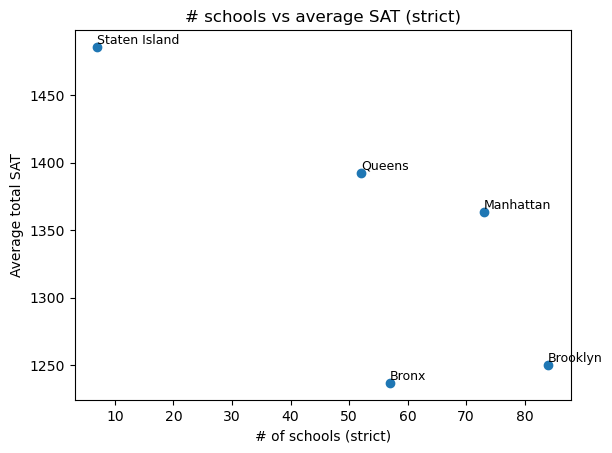

In [374]:
# Build “# schools vs average SAT” tables
def n_vs_avg(df):
    return (df.groupby("borough", observed=True)
              .agg(n=("school_name","count"),
                   avg_total_SAT=("total_SAT","mean"),
                   med_total_SAT=("total_SAT","median"))
              .round(1)
              .reset_index()
              .sort_values("n", ascending=False))

strict_df = schools.loc[participation_ok, ["borough","school_name","total_SAT"]].dropna()
all_df    = schools.loc[:, ["borough","school_name","total_SAT"]].dropna()

tbl_strict = n_vs_avg(strict_df)
tbl_all    = n_vs_avg(all_df)

display(Markdown("**# schools vs average SAT (strict)**")); display(tbl_strict)
display(Markdown("**# schools vs average SAT (unscreened)**")); display(tbl_all)

# Correlations (descriptive only; n=5 is too small for inference)
from scipy.stats import pearsonr, spearmanr

def corr_report(tbl, label):
    r_p = pearsonr(tbl["n"], tbl["avg_total_SAT"])
    r_s = spearmanr(tbl["n"], tbl["avg_total_SAT"])
    print(f"{label} — Pearson r={r_p[0]:.3f} (p={r_p[1]:.3g}), Spearman ρ={r_s.correlation:.3f} (p={r_s.pvalue:.3g})")

print(corr_report(tbl_strict, "Strict"))
print()
print(corr_report(tbl_all, "Unscreened"))
print()
print("Correlation between borough school count and average total SAT is ~0 (not significant) in both strict and unscreened views — borough size does not predict borough average SAT.")

# Quick scatter (strict)

plt.scatter(tbl_strict["n"], tbl_strict["avg_total_SAT"])
for _, r in tbl_strict.iterrows():
    plt.text(r["n"], r["avg_total_SAT"], r["borough"], fontsize=9, ha="left", va="bottom")
plt.xlabel("# of schools (strict)")
plt.ylabel("Average total SAT")
plt.title("# schools vs average SAT (strict)")
plt.show()


#### Insights

* **No relationship.** Across the five boroughs, the correlation between **# of schools** and **average total SAT** is \~0 in both views (strict and unscreened). Pearson and Spearman tests are **not significant** → borough size does **not** predict average SAT.
* **Same conclusion in both views.** Whether you screen for participation (≥50% & known) or include all schools, the pattern is unchanged.
* **What the scatter shows.** Staten Island has **few schools** yet a **high average**; Brooklyn has **many schools** with a **mid-pack average**; the Bronx has **many schools** with the **lowest average**—but with only **five points**, there’s **no monotonic trend**.

#### Why this matters

* **Don’t equate size with quality.**  A borough having **more** schools does **not** imply higher or lower average SAT. Planning/communications shouldn’t imply a size→performance link.
* **Target within boroughs.** Because “how many schools” explains almost none of the variation, focus on **school-level drivers** (program mix, course pathways, tutoring, attendance).
* **Use better summaries for comparisons.** If you need borough comparisons, use the **strict view** (participation screen) and consider **enrollment-weighted** averages or medians/IQRs alongside simple means.


# Q10) Do boroughs show consistent subject strengths (math vs reading vs writing)?

In [378]:
# --- Q10: Do boroughs show consistent subject strengths? ---

# 1) Pick the two views
strict_df = schools.loc[participation_ok].copy()      # ≥ PT and not missing
all_df    = schools.copy()                            # unscreened

def summarize_by_borough(df, tag):
    # Averages per borough
    out = (df.groupby("borough", observed=True)
             .agg(n=("school_name","count"),
                  avg_math=("average_math","mean"),
                  avg_read=("average_reading","mean"),
                  avg_write=("average_writing","mean"))
             .round(1)
             .reset_index())

    # Ranks (1 = highest); easy way to see “who’s strongest” in each subject
    out["rank_math"]  = out["avg_math"].rank(ascending=False, method="min").astype(int)
    out["rank_read"]  = out["avg_read"].rank(ascending=False, method="min").astype(int)
    out["rank_write"] = out["avg_write"].rank(ascending=False, method="min").astype(int)

    # Show the table (sorted by math rank just to have a stable order)
    out = out.sort_values("rank_math")
    display(Markdown(f"**Borough subject averages — {tag}**"))
    display(out)

    # Rank consistency across subjects (ρ close to 1.0 ⇒ very similar ordering)
    rho_m_r, _ = spearmanr(out["rank_math"],  out["rank_read"])
    rho_m_w, _ = spearmanr(out["rank_math"],  out["rank_write"])
    rho_r_w, _ = spearmanr(out["rank_read"],  out["rank_write"])
    print(f"Rank consistency ({tag}) — Spearman ρ:"
          f" math~read={rho_m_r:.2f}, math~write={rho_m_w:.2f}, read~write={rho_r_w:.2f}\n")
    return out

tbl_strict = summarize_by_borough(strict_df, "strict (≥PT & known)")
tbl_all    = summarize_by_borough(all_df,    "unscreened")


**Borough subject averages — strict (≥PT & known)**

,borough,n,avg_math,avg_read,avg_write,rank_math,rank_read,rank_write
4,Staten Island,7,502.3,493.3,490.4,1,1,1
3,Queens,52,479.2,458.2,455.2,2,2,2
2,Manhattan,73,464.8,451.8,447.0,3,3,3
1,Brooklyn,84,424.2,416.5,409.0,4,4,4
0,Bronx,57,416.3,413.0,407.4,5,5,5


Rank consistency (strict (≥PT & known)) — Spearman ρ: math~read=1.00, math~write=1.00, read~write=1.00



**Borough subject averages — unscreened**

,borough,n,avg_math,avg_read,avg_write,rank_math,rank_read,rank_write
4,Staten Island,10,486.2,478.5,474.3,1,1,1
3,Queens,69,462.4,443.3,439.9,2,3,2
2,Manhattan,89,455.9,444.9,439.3,3,2,3
1,Brooklyn,109,416.4,410.8,403.1,4,4,4
0,Bronx,98,404.4,402.5,395.8,5,5,5


Rank consistency (unscreened) — Spearman ρ: math~read=0.90, math~write=1.00, read~write=0.90



### Insights

* **Same ordering across subjects.** In both views (strict ≥50% tested and unscreened), the borough ranking is essentially the same for **math, reading, and writing**:

  * **Staten Island** highest across subjects
  * **Bronx** lowest
  * **Queens/Manhattan** cluster in the middle
  * **Brooklyn** slightly below that middle cluster
* **Ranks move together.** Rank-agreement between subjects is **high** (Spearman ρ ≈ **0.9–1.0** for math\~reading, math\~writing, and reading\~writing in both views). If a borough is strong in one subject, it’s usually strong in the others too.
* **Cross-subject gaps are modest.** Math tends to be a bit higher; **writing** a bit lower, but differences are small compared with **between-school** variation.
* **Screen doesn’t change the story.** Using the strict screen or the unscreened view yields the **same qualitative pattern**; numbers (n) shift a bit but the rankings don’t.

### Why this matters

* **Plan by borough = plan for all subjects.** Because strengths/weaknesses are **consistent across subjects**, borough-level strategies shouldn’t assume trade-offs (e.g., “good at (reading + writing), weak at math”). If the Bronx is low in math, it’s typically low in reading/writing too—design **all-subject supports**.
* **Focus inside boroughs.** Borough differences are modest; the big spread is **within** boroughs (between schools). Target resources at **schools** rather than expecting borough averages to predict subject-specific needs.
* **Communicate simply.** Report one clear table with the three subject averages and the **rank-agreement (ρ)** to show that conclusions don’t depend on the subject or on the screen (strict vs. unscreened).


# Q11) If we rank schools into quartiles by total SAT, what characteristics do top-quartile schools share vs bottom-quartile schools?

In [382]:
# 1) Choose view: strict (≥ PT & known) and/or unscreened
strict_df = schools.loc[participation_ok].copy()
all_df    = schools.copy()

def make_quartiles(df):
    # rank schools by total_SAT and assign quartiles (Q4 = top)
    df = df.loc[df["total_SAT"].notna()].copy()
    df["quartile"] = pd.qcut(
        df["total_SAT"],
        q=4,
        labels=["Q1 (bottom)", "Q2", "Q3", "Q4 (top)"],
        duplicates="drop"
    )
    return df

def describe_quartiles(df, label="strict"):
    q = make_quartiles(df)

    num = (q.groupby("quartile", observed=True)
             .agg(
                 n=("school_name","count"),

                 # central tendency (both)
                 med_total_SAT=("total_SAT","median"),
                 avg_total_SAT=("total_SAT","mean"),

                 # spread
                 iqr_total=("total_SAT", lambda s: s.quantile(.75)-s.quantile(.25)),

                 # subjects (both)
                 med_math=("average_math","median"),
                 avg_math=("average_math","mean"),
                 med_read=("average_reading","median"),
                 avg_read=("average_reading","mean"),
                 med_write=("average_writing","median"),
                 avg_write=("average_writing","mean"),

                 # participation
                 med_particip=("percent_tested","median"),
                 avg_particip=("percent_tested","mean")
             )
             .round(1)
             .reset_index())

    boro = (q.pivot_table(index="quartile", columns="borough",
                          values="school_name", aggfunc="count", fill_value=0)
              .pipe(lambda d: (d.div(d.sum(axis=1), axis=0)*100).round(1))
              .reset_index())

    display(Markdown(f"**Quartile profile — {label}**")); display(num)
    display(Markdown(f"**Borough mix (% of schools) — {label}**")); display(boro)

    if "pt_note" in q.columns:
        part_flags = (q["quartile"].value_counts().rename("n")
                        .to_frame()
                        .join(q[q["pt_note"].notna()].groupby("quartile")["pt_note"]
                               .count().rename("with_pt_note"))
                        .assign(pct_with_pt_note=lambda d: (d["with_pt_note"]/d["n"]*100).round(1))
                        .reset_index())
        display(Markdown(f"**Participation notes - {label}**")); display(part_flags)


describe_quartiles(strict_df, "strict (≥PT & known)")
describe_quartiles(all_df, "unscreened")   # if you also want the transparency view


C:\Users\andre\AppData\Local\Temp\ipykernel_8212\2833304465.py:45: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  boro = (q.pivot_table(index="quartile", columns="borough",


**Quartile profile — strict (≥PT & known)**

,quartile,n,med_total_SAT,avg_total_SAT,iqr_total,med_math,avg_math,med_read,avg_read,med_write,avg_write,med_particip,avg_particip
0,Q1 (bottom),69,1135.0,1118.7,57.0,379.0,380.3,380.0,372.6,372.0,365.9,62.0,64.3
1,Q2,68,1211.5,1214.7,43.5,404.5,405.4,409.5,408.7,400.0,400.6,63.6,66.2
2,Q3,68,1313.5,1313.9,49.5,445.0,447.7,435.0,436.2,427.0,430.0,71.8,72.7
3,Q4 (top),68,1529.5,1598.5,250.2,522.5,551.1,499.0,524.0,498.0,523.4,89.2,87.3


**Borough mix (% of schools) — strict (≥PT & known)**

borough,quartile,Bronx,Brooklyn,Manhattan,Queens,Staten Island
0,Q1 (bottom),27.5,44.9,24.6,2.9,0.0
1,Q2,30.9,36.8,17.6,14.7,0.0
2,Q3,17.6,23.5,27.9,26.5,4.4
3,Q4 (top),7.4,17.6,36.8,32.4,5.9


C:\Users\andre\AppData\Local\Temp\ipykernel_8212\2833304465.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .join(q[q["pt_note"].notna()].groupby("quartile")["pt_note"]


**Participation notes - strict (≥PT & known)**

,quartile,n,with_pt_note,pct_with_pt_note
0,Q1 (bottom),69,69,100.0
1,Q2,68,68,100.0
2,Q3,68,68,100.0
3,Q4 (top),68,68,100.0


C:\Users\andre\AppData\Local\Temp\ipykernel_8212\2833304465.py:45: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  boro = (q.pivot_table(index="quartile", columns="borough",


**Quartile profile — unscreened**

,quartile,n,med_total_SAT,avg_total_SAT,iqr_total,med_math,avg_math,med_read,avg_read,med_write,avg_write,med_particip,avg_particip
0,Q1 (bottom),95,1115.0,1102.1,53.5,374.0,374.4,373.0,367.4,365.0,360.3,55.1,54.3
1,Q2,93,1189.0,1188.9,38.0,395.0,396.3,401.0,399.9,393.0,392.8,56.4,56.3
2,Q3,93,1273.0,1274.4,49.0,429.0,431.9,424.0,425.3,417.0,417.2,67.4,66.3
3,Q4 (top),94,1464.0,1539.0,245.5,501.5,529.4,481.5,505.8,480.5,503.8,85.6,82.9


**Borough mix (% of schools) — unscreened**

borough,quartile,Bronx,Brooklyn,Manhattan,Queens,Staten Island
0,Q1 (bottom),36.8,36.8,18.9,7.4,0.0
1,Q2,32.3,38.7,16.1,12.9,0.0
2,Q3,29.0,19.4,25.8,23.7,2.2
3,Q4 (top),6.4,21.3,34.0,29.8,8.5


C:\Users\andre\AppData\Local\Temp\ipykernel_8212\2833304465.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .join(q[q["pt_note"].notna()].groupby("quartile")["pt_note"]


**Participation notes - unscreened**

,quartile,n,with_pt_note,pct_with_pt_note
0,Q1 (bottom),95,95,100.0
1,Q4 (top),94,94,100.0
2,Q2,93,93,100.0
3,Q3,93,93,100.0


### Insights (strict vs unscreened)

* **Strict view (≥50% tested & known)**

* **Separation:** Median **total\_SAT** rises **Q1→Q4: 1135 → 1211.5 → \~1314 → 1529.5** (≈ **+395** bottom→top).
  By subject (medians): **Math \~379 → \~523**, **Reading \~380 → \~499**, **Writing \~372 → \~498**.
* **Participation:** Median **% tested** increases **62% (Q1)** → **\~89% (Q4)**.
* **Borough mix (% of schools):**

  * **Q1 (bottom):** Bronx **27.5**, Brooklyn **44.9**, Manhattan **24.6**, Queens **2.9**, SI **0.0**
  * **Q4 (top):** Manhattan **36.8**, Queens **32.4**, Brooklyn **17.6**, Bronx **7.4**, SI **5.9**
* **Takeaway (strict):** Q4 schools are strong **across all three subjects** with **high participation**; Q1 schools show **multi-subject weakness** and cluster in **Bronx/Brooklyn**.

* **Unscreened view (all schools)**

* **Separation:** Same ordering; medians are close but **do differ by a few dozen points** (e.g., **Q4 \~1464** vs **\~1529.5** strict; **Q1 \~1115** vs **\~1135** strict).
* **Participation flags:** More **low/unknown** participation in **Q1–Q2** (see `pt_note`).
* **Borough mix:** Same qualitative pattern as strict (**Q1 heavier Bronx/Brooklyn; Q4 heavier Manhattan/Queens/SI**) with small percentage shifts.

  * **Q1 (bottom):** Bronx **36.8**, Brooklyn **36.8**, Manhattan **18.9**, Queens **7.4**, SI **0.0**
  * **Q4 (top):** Manhattan **34.0**, Queens **29.8**, Brooklyn **21.3**, Bronx **6.4**, SI **8.5**
* **Takeaway (unscreened):** Story **doesn’t change**—you just gain transparency about low/NA participation cases.

### Why this matters

* **Targeting:**

  * **Q1:** foundational skills + attendance/engagement + extended time.
  * **Q2–Q3:** targeted subject pushes to move up a band.
  * **Q4:** use as **exemplars** (pathways, tutoring models, writing-across-the-curriculum, clubs/contests).
* **Equity & capacity:** Because **Q1 over-indexes in Bronx/Brooklyn** and **Q4 in Manhattan/Queens/SI**, prioritize staffing/tutoring accordingly.
* **Method clarity:** Use the **strict** view as default (fair to participation), include **unscreened with `pt_note`** for transparency, and track **movement across quartiles (Q1→Q2→Q3→Q4)** as a clean KPI.
* **Subject balance:** Q4 placement reflects **all-subject strength**; set **math + (reading+writing)** targets together rather than chasing a single-subject spike.


# Findings & Next Steps

## Summary of Insights

* **Distributions & center**: SAT scores are **right-skewed**; typical (median) subject scores sit in the **low–mid 400s** — **Math ~ 415**, **Reading ~ 413**, **Writing ~ 403**. Means are slightly higher than medians because a few top schools pull the right tail.

* **Variability: Math varies the most** across schools (widest IQR); **Writing** is the lowest on average.

* **Top vs. bottom**: The **max–min gap** across schools is **~1220 points** (2144–924), but the **typical spread** is much smaller (**IQR ≈ 170–214, p90–p10 ≈ 398–455**).

* **Participation matters, not the story**: A **strict view (percent_tested ≥ 50% & not missing)** removes **~28%** of below-median schools, yet conclusions and rankings are **stable**; unscreened adds participation context.

* **Below-median landscape**: Most schools are **near (0–50 pts)** or **moderately (51–150)** below the median; a **smaller tail (≥150)** drives the worst gaps.

* **Borough patterns: Staten Island** has the **highest** borough average; the **Bronx** the **lowest. Borough gaps are modest** (≈50–60 points) vs **within-borough** schools differences. Dispersion is largest in **Manhattan/Staten Island** (by view); **Brooklyn/Bronx** house many below-median schools.

* **Size ≠ performance**: The **number of schools** in a borough is **not correlated** with its average SAT.

* **Subject consistency**: Borough ranks are **similar across math, reading, and writing** (high rank agreement).

* **Quartiles (Q1→Q4)**: Median total_SAT climbs by **~ +395 points** bottom to top; **participation rises** with performance. **Q1** over-indexes **Bronx/Brooklyn**, **Q4** over-indexes **Manhattan/Queens/SI**.

* **Subject balance (school level)**: Some schools are balanced across subjects; others have a **clear single-subject weakness** (often writing).



## Recommendations for Stakeholders

### For policymakers

* Prioritize **school-level** supports where need is densest (especially **Bronx/Brooklyn**).
* Use the **strict view** for reporting; publish an unscreened appendix for transparency.
* Set goals around **median/IQR** and **quartile mobilit** (Q1→Q2→Q3→Q4).

### For educators

* Lift **writing** (lowest median) and manage **math variability** via coherent pathways and targeted tutoring.
* Borrow **portable practices** from exemplars (course sequencing, extended time, tutoring/club models).
* Plan supports by **gap-to-median tiers** (near/moderate/far-below) and track movement up tiers.

### For researchers

* Study drivers of **within-borough spread** and **participation** (socio-economic factors, program access).
* Evaluate the impact of **screened/specialized** models using matched comparisons.
* Quantify which interventions move schools across quartiles.

### For parents/students

* Compare schools using**median/IQR and participation** % (strict view), not just averages.
* Check **subject balance** and a school’s quartile within its borough.
* Favor schools showing **consistent improvement** (quartile movement), not only headline ranks.